In [40]:
#!/usr/bin/env julia
using Yao
using Yao.ConstGate # needed for P1 = 0.5*(I - sigma_z) block

using PyPlot
import PyPlot.plt

using PyCall
@pyimport matplotlib as mpl

using Random


In [21]:
#=
H(t) = Ω(t) ∑_i σ_i^x - δ(t) ∑_i n_i + u ∑_ij n_i n_j
=#

const u = 1.35
const Ω_max = 1.89
const δ_0 = -1.0
const δ_max = 1.0

function get_edges(graph::Vector{NTuple{2, Float64}})
    Nv = size(graph)[1]
    edges = falses(Nv, Nv)
    for i in 1:(Nv-1)
        xi, yi = graph[i]
        for j in (i+1):Nv
            xj, yj = graph[j]

            dij = sqrt((xi - xj)^2. + (yi - yj)^2.)
            if dij <= 1.0
                edges[i,j] = true
            end
        end
    end
    return findall(edges)
end

function Ω(t::Float64)
    if 0 <= t <= 0.25
        return (Ω_max / 0.25) * t
    elseif 0.25 < t <= 0.69
        return Ω_max
    elseif 0.69 < t <= 1
        return - Ω_max * t / 0.31 + Ω_max * (1 + 0.69/0.31)
    end
end

function δ(t::Float64)
    slope = (δ_0 - δ_max)/(0.25 - 0.69)
    if 0 <= t <= 0.25
        return δ_0
    elseif 0.25 < t <= 0.69
        return t * slope + (δ_max - slope * 0.69)
    elseif 0.69 < t <= 1
        return δ_max
    end
end 

function hamiltonian(graph::Vector{NTuple{2, Float64}}, edges::Vector{CartesianIndex{2}}, t::Float64)
    # the UD-MIS Hamiltonian
    Nv = size(graph)[1] # number of vertices

    interaction_term = map(1:size(edges)[1]) do i
        l,m = edges[i][1], edges[i][2]
        repeat(Nv,u*P1,(l,m))
    end |> sum
    interaction_term - δ(t)*sum(map(i->put(Nv,i=>P1), 1:Nv)) + Ω(t)*sum(map(i->put(Nv,i=>X), 1:Nv))
end

function run_annealing(graph::Vector{NTuple{2, Float64}}, edges::Vector{CartesianIndex{2}}, dt::Float64)
    psi_t = zero_state(size(graph)[1])
    for t in 0:dt:1.0
        h = hamiltonian(graph, edges, t)
        psi_t = psi_t |> TimeEvolution(h, dt * 100)
    end
    return psi_t
end

ArrayReg{1, ComplexF64, Array...}
    active qubits: 6/6

In [123]:
num_vertices = 7

graph = [(rand()*3,rand()*3)]
for i in 1:num_vertices-1
    graph = push!(graph, (rand()*3,rand()*3))
end
    
    
# graph = [(0.3461717838632017, 1.4984640297338632), 
#          (0.6316400411846113, 2.5754677320579895), 
#          (1.3906262250927481, 2.164978861396621), 
#          (0.66436005100802, 0.6717919819739032), 
#          (0.8663329771713457, 3.3876341010035995), 
#          (1.1643107343501296, 1.0823066243402013)
#         ]
edges = get_edges(graph)
dt = 0.001

psi = run_annealing(graph, edges, dt)
# open("task2_data.dat","w") do io
#     for sample in measure(psi; nshots=10_000)
#         println(io, sample)
#     end
# end

#samples = measure(psi; nshots=10)
#@show samples

ArrayReg{1, ComplexF64, Array...}
    active qubits: 7/7

In [129]:
# Find the most frequent bit string
meas = Dict()
for sample in measure(psi; nshots=10000)
    if sample in keys(meas)
        meas[sample]+=1
    else
        meas[sample] = 1
    end
end

most_freq_bitstring= collect(keys(meas))[argmax(collect(values(meas)))]
print(most_freq_bitstring)
meas[most_freq_bitstring]

0101010 ₍₂₎

4509

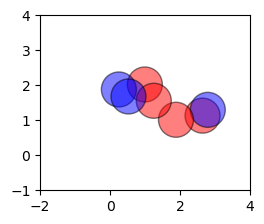

(-1.0, 4.0)

In [125]:
# Plotting the solution 
occupation = string(most_freq_bitstring,2)[1:length(graph)]
patches = mpl.pymember("patches")
fig = plt.figure(figsize=(3,3))
ax = fig[:add_axes]([0.2,0.2,0.7,0.7],aspect =1)
colors = ["r","b"]
# p = patches[:Polygon](rand(4,2),closed=true,edgecolor="none",facecolor="blue",rasterized=true)
for i in 1:length(graph)
    x,y = graph[i]
    circle1 = patches[:Circle]((x, y), radius = 0.5, edgecolor="black", 
        alpha = 0.5,facecolor=colors[parse(Int, occupation[i])+1])
    ax[:add_patch](circle1)
end
ax[:plot]()

ax[:set_xlabel]("")
ax[:set_ylabel]("")
ax[:set_xlim]([-2,4])
ax[:set_ylim]([-1,4])